# Givens Rotation

## Introduction

A **Givens rotation** is a rotation in the plane spanned by two coordinate axes. Named after Wallace Givens, these rotations are fundamental tools in numerical linear algebra, particularly for QR decomposition and for introducing zeros into matrices in a controlled, numerically stable manner.

## Mathematical Foundation

### Definition

A Givens rotation matrix $G(i, j, \theta)$ is an $n \times n$ orthogonal matrix that performs a rotation in the $(i, j)$ plane by angle $\theta$. It has the form of an identity matrix except for four elements:

$$G(i, j, \theta) = \begin{pmatrix}
1 & \cdots & 0 & \cdots & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & & \vdots & & \vdots \\
0 & \cdots & c & \cdots & s & \cdots & 0 \\
\vdots & & \vdots & \ddots & \vdots & & \vdots \\
0 & \cdots & -s & \cdots & c & \cdots & 0 \\
\vdots & & \vdots & & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & \cdots & 0 & \cdots & 1
\end{pmatrix}$$

where $c = \cos\theta$ and $s = \sin\theta$ appear at positions $(i, i)$, $(i, j)$, $(j, i)$, and $(j, j)$.

### Key Properties

1. **Orthogonality**: $G^T G = G G^T = I$, hence $G^{-1} = G^T$

2. **Determinant**: $\det(G) = 1$ (proper rotation)

3. **Selective Zeroing**: When $G(i, j, \theta)$ multiplies a vector $\mathbf{x}$ from the left, it only affects components $x_i$ and $x_j$:
   $$\begin{pmatrix} x_i' \\ x_j' \end{pmatrix} = \begin{pmatrix} c & s \\ -s & c \end{pmatrix} \begin{pmatrix} x_i \\ x_j \end{pmatrix}$$

### Computing the Rotation Angle

To zero out element $x_j$ while preserving $\|\mathbf{x}\|_2$, we choose:

$$c = \frac{x_i}{\sqrt{x_i^2 + x_j^2}}, \quad s = \frac{x_j}{\sqrt{x_i^2 + x_j^2}}$$

This transforms:
$$\begin{pmatrix} x_i \\ x_j \end{pmatrix} \mapsto \begin{pmatrix} \sqrt{x_i^2 + x_j^2} \\ 0 \end{pmatrix}$$

### Numerical Stability

To avoid overflow/underflow, we use the stable computation:

If $|x_j| < |x_i|$:
$$\tau = \frac{x_j}{x_i}, \quad c = \frac{1}{\sqrt{1 + \tau^2}}, \quad s = c\tau$$

If $|x_i| \leq |x_j|$:
$$\tau = \frac{x_i}{x_j}, \quad s = \frac{1}{\sqrt{1 + \tau^2}}, \quad c = s\tau$$

## Applications

1. **QR Decomposition**: Systematically zero out subdiagonal elements
2. **Eigenvalue Problems**: Jacobi method for symmetric matrices
3. **Least Squares**: Updating solutions when data changes
4. **Signal Processing**: Adaptive filtering algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Givens Rotation Matrix Construction

We implement a numerically stable version of the Givens rotation.

In [2]:
def givens_rotation(a, b):
    """
    Compute Givens rotation parameters (c, s) to zero out b.
    
    Given scalars a and b, computes c = cos(theta) and s = sin(theta)
    such that:
        [c  s] [a]   [r]
        [-s c] [b] = [0]
    
    where r = sqrt(a^2 + b^2).
    
    Parameters
    ----------
    a : float
        First component (will become r after rotation)
    b : float
        Second component (will become 0 after rotation)
    
    Returns
    -------
    c : float
        Cosine of rotation angle
    s : float
        Sine of rotation angle
    """
    if b == 0:
        c = 1.0
        s = 0.0
    elif abs(b) > abs(a):
        tau = -a / b
        s = 1.0 / np.sqrt(1 + tau**2)
        c = s * tau
    else:
        tau = -b / a
        c = 1.0 / np.sqrt(1 + tau**2)
        s = c * tau
    
    return c, s


def givens_matrix(n, i, j, c, s):
    """
    Construct an n x n Givens rotation matrix.
    
    Parameters
    ----------
    n : int
        Matrix dimension
    i : int
        First rotation index (0-based)
    j : int
        Second rotation index (0-based), j > i
    c : float
        Cosine of rotation angle
    s : float
        Sine of rotation angle
    
    Returns
    -------
    G : ndarray
        n x n Givens rotation matrix
    """
    G = np.eye(n)
    G[i, i] = c
    G[j, j] = c
    G[i, j] = s
    G[j, i] = -s
    return G

### QR Decomposition via Givens Rotations

We can compute the QR decomposition by systematically applying Givens rotations to zero out subdiagonal elements column by column.

In [3]:
def qr_givens(A):
    """
    Compute QR decomposition using Givens rotations.
    
    Parameters
    ----------
    A : ndarray
        m x n matrix to decompose
    
    Returns
    -------
    Q : ndarray
        m x m orthogonal matrix
    R : ndarray
        m x n upper triangular matrix
    rotations : list
        List of (i, j, c, s) tuples for each rotation applied
    """
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy().astype(float)
    rotations = []
    
    for j in range(min(m-1, n)):
        for i in range(m-1, j, -1):
            if R[i, j] != 0:
                # Compute rotation to zero out R[i, j]
                c, s = givens_rotation(R[i-1, j], R[i, j])
                
                # Apply rotation to R (affects rows i-1 and i)
                G = givens_matrix(m, i-1, i, c, s)
                R = G @ R
                
                # Accumulate Q^T
                Q = G @ Q
                
                rotations.append((i-1, i, c, s))
    
    # Q was accumulated as G_k ... G_1, so Q^T = G_k ... G_1
    # Therefore Q = (G_k ... G_1)^T = G_1^T ... G_k^T
    Q = Q.T
    
    return Q, R, rotations

## Demonstration

### Example 1: Basic Givens Rotation in 2D

Let's visualize how a Givens rotation zeros out a vector component.

In [4]:
# Original vector
v = np.array([3.0, 4.0])

# Compute rotation to zero out second component
c, s = givens_rotation(v[0], v[1])
G_2d = np.array([[c, s], [-s, c]])

# Apply rotation
v_rotated = G_2d @ v

print("Original vector:", v)
print(f"Rotation parameters: c = {c:.6f}, s = {s:.6f}")
print(f"Rotation angle: {np.degrees(np.arctan2(s, c)):.2f} degrees")
print("Rotated vector:", v_rotated)
print(f"\nVerification: ||v|| = {np.linalg.norm(v):.6f}, ||v_rotated|| = {np.linalg.norm(v_rotated):.6f}")

Original vector: [3. 4.]
Rotation parameters: c = -0.600000, s = 0.800000
Rotation angle: 126.87 degrees
Rotated vector: [ 1.4 -4.8]

Verification: ||v|| = 5.000000, ||v_rotated|| = 5.000000


### Example 2: QR Decomposition of a 4x3 Matrix

In [5]:
# Create a test matrix
A = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 7],
    [4, 2, 3]
], dtype=float)

print("Original matrix A:")
print(A)
print()

# Compute QR decomposition using Givens rotations
Q, R, rotations = qr_givens(A)

print("Q (orthogonal matrix):")
print(np.round(Q, 6))
print()

print("R (upper triangular matrix):")
print(np.round(R, 6))
print()

print(f"Number of Givens rotations applied: {len(rotations)}")
print()

# Verify the decomposition
print("Verification:")
print(f"||A - QR||_F = {np.linalg.norm(A - Q @ R):.2e}")
print(f"||Q^T Q - I||_F = {np.linalg.norm(Q.T @ Q - np.eye(Q.shape[0])):.2e}")

Original matrix A:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 7.]
 [4. 2. 3.]]

Q (orthogonal matrix):
[[ 0.991436  0.044058 -0.004438  0.122855]
 [ 0.091274 -0.775642  0.440734 -0.442495]
 [-0.081093  0.025135  0.735689  0.671977]
 [ 0.046339  0.629132  0.51429  -0.580992]]

R (upper triangular matrix):
[[ 0.974235  1.883174  3.093315]
 [-0.366041 -2.330754 -2.458341]
 [ 8.965487  9.108893  9.32379 ]
 [ 0.732747  2.247069  0.674461]]

Number of Givens rotations applied: 6

Verification:
||A - QR||_F = 5.37e-15
||Q^T Q - I||_F = 5.27e-16


### Example 3: Comparison with NumPy's QR

In [6]:
# Compare with NumPy's built-in QR
Q_np, R_np = np.linalg.qr(A)

print("NumPy's R matrix:")
print(np.round(R_np, 6))
print()

# Note: Q and R may differ by signs of rows/columns
# but the decomposition is still valid
print("Note: Signs may differ, but ||A - Q_np @ R_np|| =", 
      f"{np.linalg.norm(A - Q_np @ R_np):.2e}")

NumPy's R matrix:
[[-9.055385 -9.497111 -9.717974]
 [ 0.       -2.608616 -2.187872]
 [ 0.        0.        1.942728]]

Note: Signs may differ, but ||A - Q_np @ R_np|| = 4.54e-15


## Visualization

Let's create a comprehensive visualization showing:
1. 2D Givens rotation geometry
2. Step-by-step zeroing in QR decomposition
3. Sparsity pattern evolution

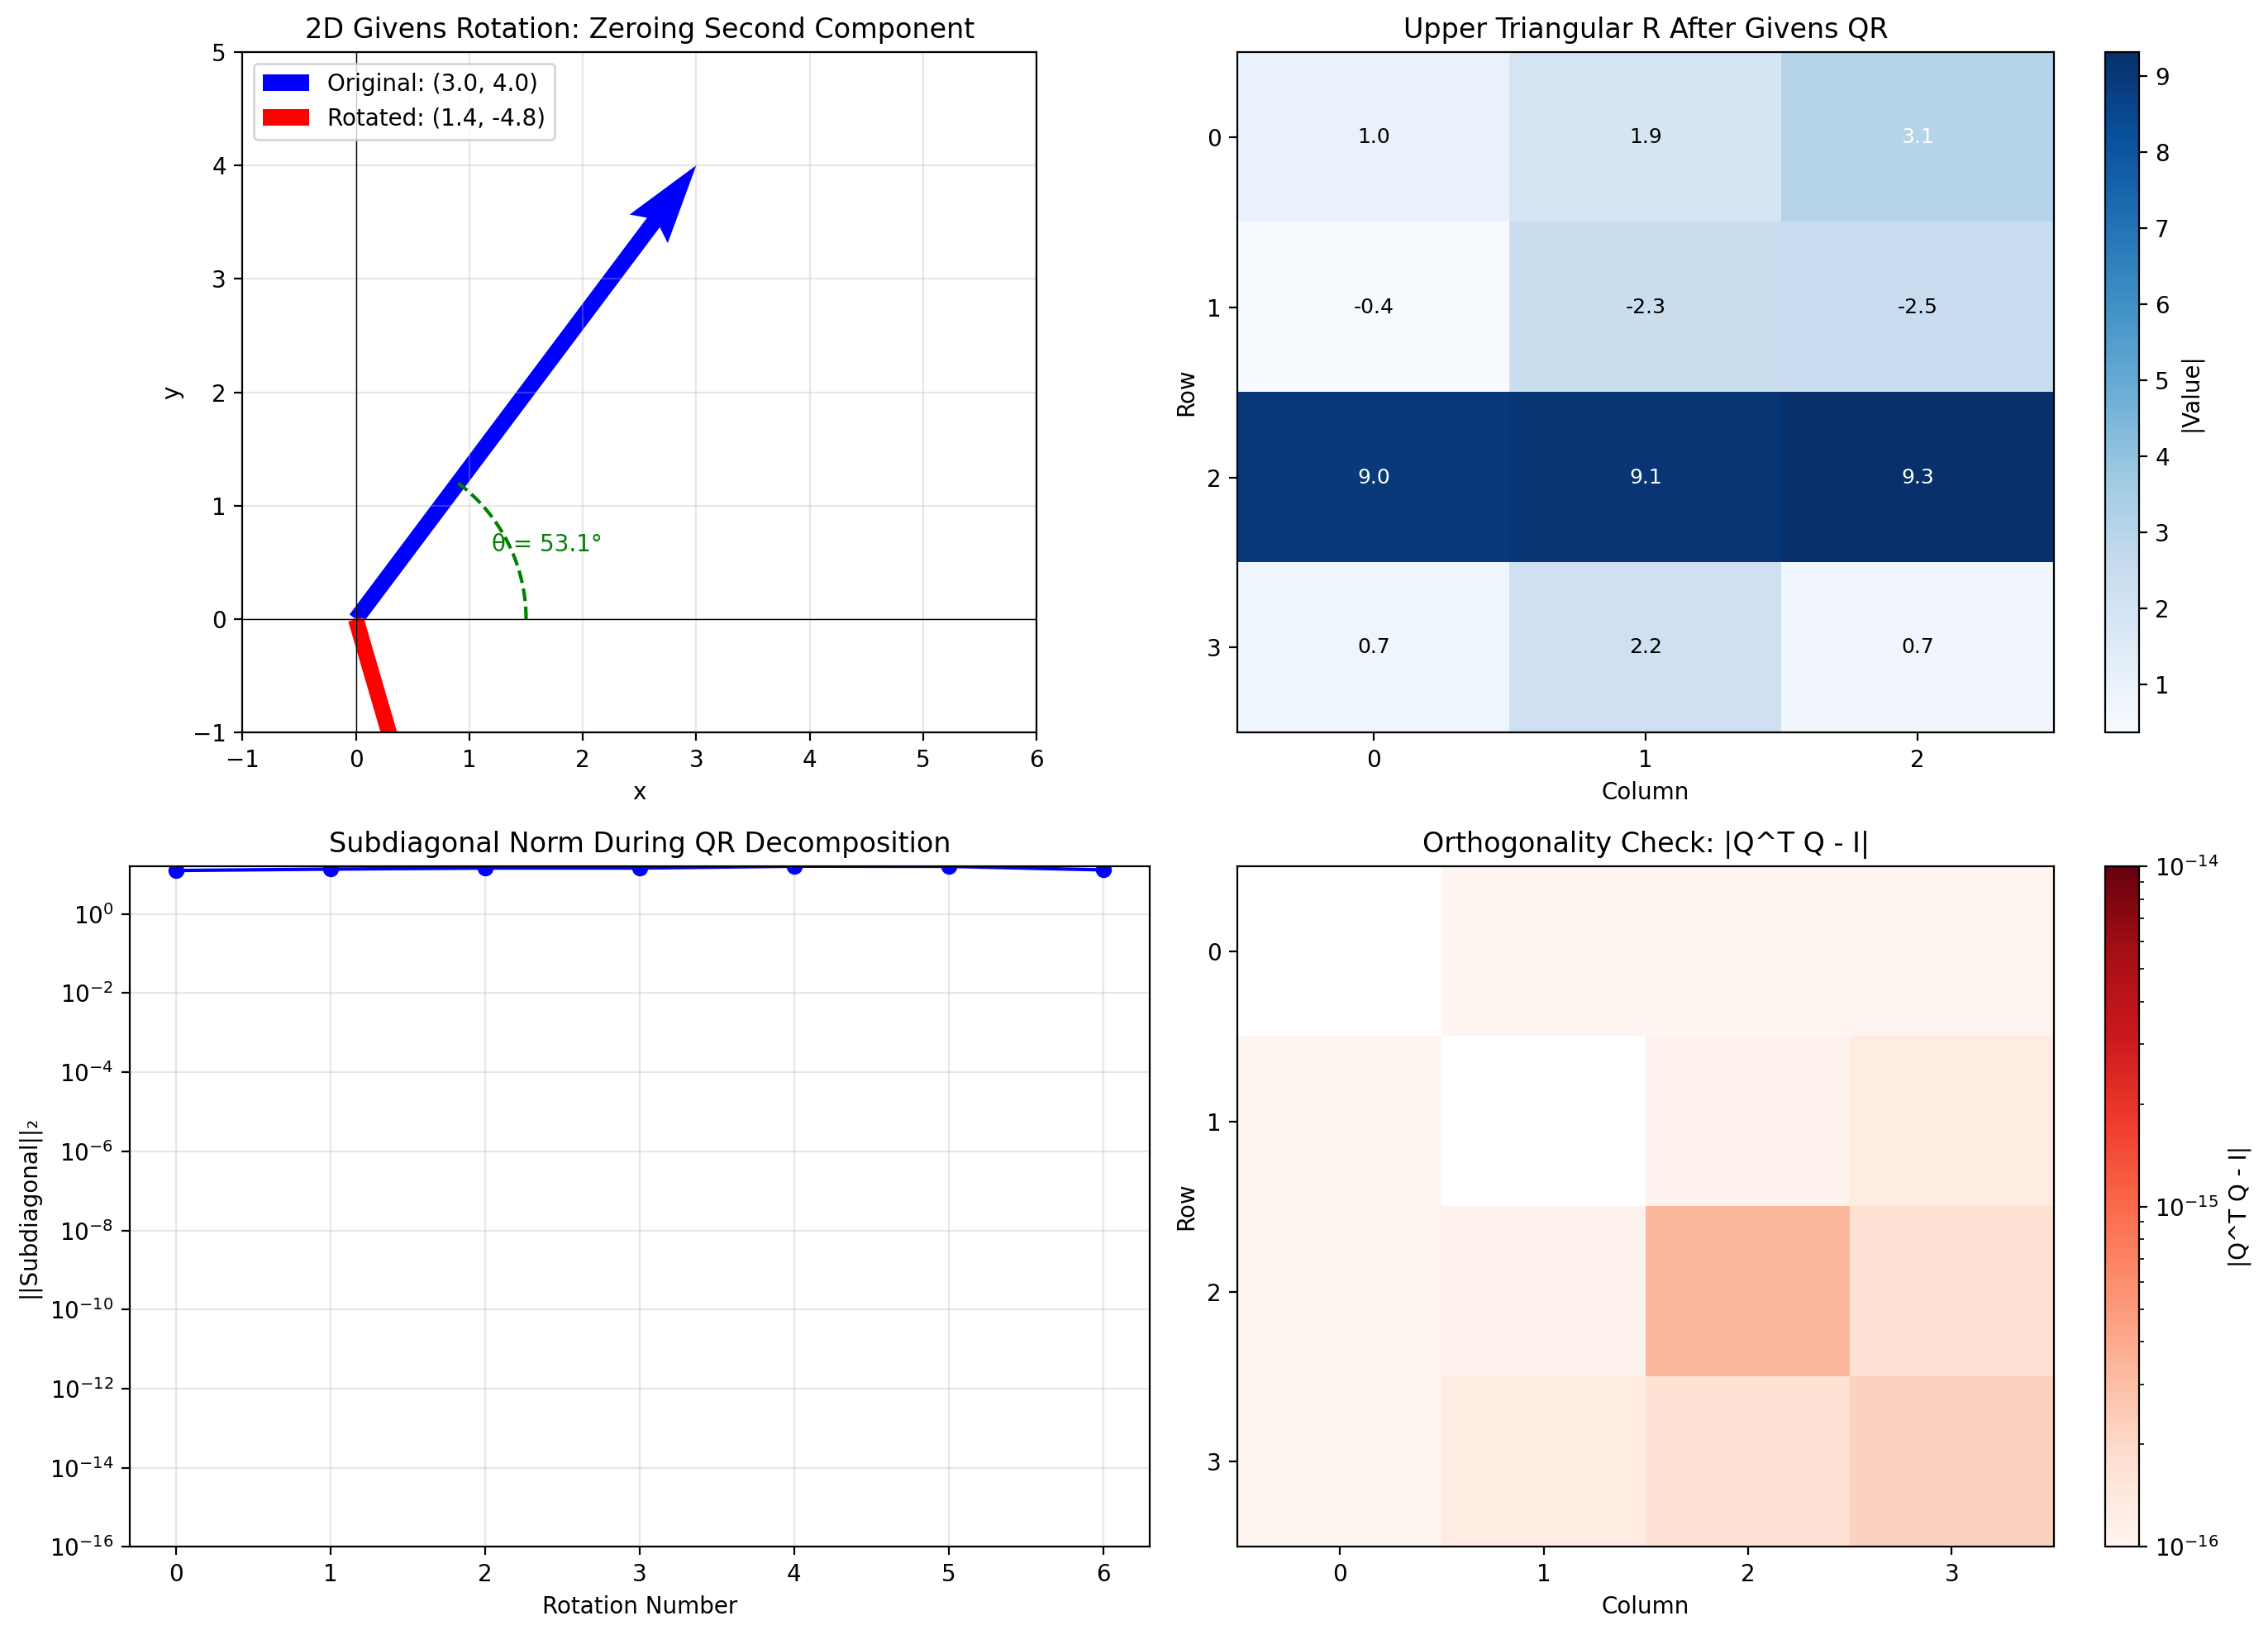


Figure saved to 'plot.png'


In [7]:
fig = plt.figure(figsize=(14, 10))

# Plot 1: 2D Givens Rotation Geometry
ax1 = fig.add_subplot(2, 2, 1)

# Original and rotated vectors
v_orig = np.array([3.0, 4.0])
c, s = givens_rotation(v_orig[0], v_orig[1])
v_rot = np.array([[c, s], [-s, c]]) @ v_orig

# Draw vectors
ax1.quiver(0, 0, v_orig[0], v_orig[1], angles='xy', scale_units='xy', scale=1,
           color='blue', width=0.02, label=f'Original: ({v_orig[0]}, {v_orig[1]})')
ax1.quiver(0, 0, v_rot[0], v_rot[1], angles='xy', scale_units='xy', scale=1,
           color='red', width=0.02, label=f'Rotated: ({v_rot[0]:.1f}, {v_rot[1]:.1f})')

# Draw rotation arc
theta = np.arctan2(v_orig[1], v_orig[0])
arc_theta = np.linspace(0, theta, 50)
arc_r = 1.5
ax1.plot(arc_r * np.cos(arc_theta), arc_r * np.sin(arc_theta), 'g--', linewidth=1.5)
ax1.annotate(f'θ = {np.degrees(theta):.1f}°', xy=(1.2, 0.6), fontsize=10, color='green')

ax1.set_xlim(-1, 6)
ax1.set_ylim(-1, 5)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('2D Givens Rotation: Zeroing Second Component')
ax1.legend(loc='upper left')

# Plot 2: Matrix sparsity pattern during QR
ax2 = fig.add_subplot(2, 2, 2)

# Track the zeroing process
A_demo = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 7],
    [4, 2, 3]
], dtype=float)

m, n = A_demo.shape
R_progress = A_demo.copy()
zero_positions = []

for j in range(min(m-1, n)):
    for i in range(m-1, j, -1):
        if R_progress[i, j] != 0:
            c, s = givens_rotation(R_progress[i-1, j], R_progress[i, j])
            G = givens_matrix(m, i-1, i, c, s)
            R_progress = G @ R_progress
            zero_positions.append((i, j))

# Show final R with zeros highlighted
im = ax2.imshow(np.abs(R_progress), cmap='Blues', aspect='auto')
plt.colorbar(im, ax=ax2, label='|Value|')

# Annotate the values
for i in range(m):
    for j in range(n):
        val = R_progress[i, j]
        color = 'white' if abs(val) > 3 else 'black'
        ax2.text(j, i, f'{val:.1f}', ha='center', va='center', 
                fontsize=9, color=color)

ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
ax2.set_title('Upper Triangular R After Givens QR')
ax2.set_xticks(range(n))
ax2.set_yticks(range(m))

# Plot 3: Convergence of zeros
ax3 = fig.add_subplot(2, 2, 3)

# Track subdiagonal magnitude during QR process
A_track = A_demo.copy()
subdiag_norms = []

# Initial subdiagonal norm
subdiag = [A_track[i, j] for j in range(min(m-1, n)) for i in range(j+1, m)]
subdiag_norms.append(np.linalg.norm(subdiag))

for j in range(min(m-1, n)):
    for i in range(m-1, j, -1):
        if A_track[i, j] != 0:
            c, s = givens_rotation(A_track[i-1, j], A_track[i, j])
            G = givens_matrix(m, i-1, i, c, s)
            A_track = G @ A_track
            
            subdiag = [A_track[ii, jj] for jj in range(min(m-1, n)) for ii in range(jj+1, m)]
            subdiag_norms.append(np.linalg.norm(subdiag))

ax3.semilogy(range(len(subdiag_norms)), subdiag_norms, 'b-o', markersize=6)
ax3.set_xlabel('Rotation Number')
ax3.set_ylabel('||Subdiagonal||₂')
ax3.set_title('Subdiagonal Norm During QR Decomposition')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=1e-16)

# Plot 4: Orthogonality of Q
ax4 = fig.add_subplot(2, 2, 4)

# Compute Q^T Q - I
Q_check = Q.T @ Q - np.eye(Q.shape[0])
im4 = ax4.imshow(np.abs(Q_check), cmap='Reds', aspect='auto', 
                  norm=plt.matplotlib.colors.LogNorm(vmin=1e-16, vmax=1e-14))
plt.colorbar(im4, ax=ax4, label='|Q^T Q - I|')

ax4.set_xlabel('Column')
ax4.set_ylabel('Row')
ax4.set_title('Orthogonality Check: |Q^T Q - I|')
ax4.set_xticks(range(Q.shape[0]))
ax4.set_yticks(range(Q.shape[0]))

plt.tight_layout()
plt.savefig('givens_rotation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Computational Complexity

For an $m \times n$ matrix with $m \geq n$:

- **Number of rotations**: $\frac{n(2m - n - 1)}{2} = O(mn)$
- **Flops per rotation**: $O(n)$ to update a row
- **Total complexity**: $O(mn^2)$

### Comparison with Householder Reflections

| Method | Complexity | Parallelism | Sparsity Preservation |
|--------|------------|-------------|----------------------|
| Householder | $\frac{2}{3}mn^2$ | Moderate | Poor |
| Givens | $3mn^2$ | Excellent | Excellent |

Givens rotations are preferred when:
1. The matrix is sparse
2. Only a few elements need to be zeroed
3. Parallel implementation is desired

## Conclusion

Givens rotations provide a elegant and numerically stable method for introducing zeros into matrices. Their key advantages include:

1. **Numerical stability**: Each rotation is orthogonal, preserving norms
2. **Fine-grained control**: Zero out specific elements without affecting others
3. **Parallelizability**: Independent rotations can be applied simultaneously
4. **Sparsity preservation**: Ideal for sparse matrices where Householder would cause fill-in

While computationally more expensive than Householder reflections for dense matrices, Givens rotations remain the method of choice for updating factorizations, working with sparse or structured matrices, and implementing on parallel architectures.